In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris

In [2]:
## load data
iris = load_iris()  # np.array 格式
df = pd.DataFrame(iris.data, columns = iris.feature_names)
df['label'] = iris.target # 添加label列
df[:20] # 查看一下实际数据

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


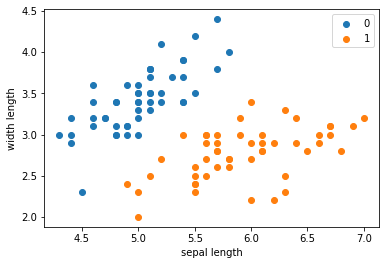

In [3]:
plt.scatter(df[:50]['sepal length (cm)'], df[:50]['sepal width (cm)'], label='0')
plt.scatter(df[50:100]['sepal length (cm)'], df[50:100]['sepal width (cm)'], label='1')
plt.xlabel('sepal length')
plt.ylabel('width length')
plt.legend()

In [4]:
data = np.array(df.iloc[:,:]) # 数据由Datafrom转化为array
X, Y = data[:, :-1], data[:, -1]

def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return X[randomize], Y[randomize]
X, Y = _shuffle(X,Y)

def _train_test_split(X, Y, split_ratio = 0.1):
    train_size = int(len(X) * (1 - split_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

X_train, Y_train, X_test, Y_test = _train_test_split(X, Y, split_ratio = 0.1)


In [5]:
## 数据标准化
def _normalize(X, train_set = True, specified_columns = None, X_mean = None, X_std = None):
    if specified_columns == None:
        specified_columns = np.arange(len(X[0]))
    if train_set:
        X_mean = np.mean(X[:, specified_columns], axis = 0)
        X_std = np.std(X[:, specified_columns], axis = 0)
    X[:, specified_columns] = (X[:,specified_columns] - X_mean) / (X_std + 1e-8)
    return X, X_mean, X_std

X_train, X_mean, X_std = _normalize(X_train, train_set=True)
X_test, _, _ = _normalize(X_test, train_set = None, X_mean = X_mean, X_std = X_std)


## 线性遍历最近的K个点

In [6]:
class KNN_LinearSearch:
    def __init__(self, X_train, Y_train, k = 3, p=2):
        """
        k: 临近点的个数
        p: 距离度量
        """
        self.k = k
        self.p = p
        self.X_train = X_train
        self.Y_train = Y_train
        
    def predict(self, X_test):
        """
        X_test，该函数找出最近的k个点，并按照多数表决规则进行预测
        """
        result = []
        for i in range(len(X_test)):
            X = X_test[i]
            knn_list = []
            for j in range(self.k):
                dist = np.linalg.norm(X - self.X_train[j], ord=self.p) #np中求线性代数范数的公式
                knn_list.append((dist, self.Y_train[j]))
            for l in range(self.k, len(self.X_train)):
                max_index = knn_list.index(max(knn_list, key=lambda x: x[0]))
                dist_new = np.linalg.norm(X-self.X_train[l], ord=self.p)
                if knn_list[max_index][0] > dist_new:
                    knn_list[max_index] = (dist, self.Y_train[l])
                    
            # 分类决策规则：多数表决
            knn_label = [k[-1] for k in knn_list]
            max_count_label = max(knn_label, key=knn_label.count)
            result.append(max_count_label)
        return result
    
    def Correct_rate(self, X_test, Y_test):
        right_count = 0
        predictions = self.predict(X_test)
        for i in range(len(Y_test)):
            if predictions[i] == Y_test[i]:
                right_count += 1
        return right_count / len(X_test)

In [7]:
KNN = KNN_LinearSearch(X_train, Y_train)

In [8]:
KNN.predict(X_test)

[1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0]

In [9]:
KNN.Correct_rate(X_test, Y_test)
## 标准化的正确率 大于 未标准化的正确率
## 由于过程中对数据进行了随机化，所以每次运行的结果不同
## 对于结果而言可以设置不同的k，并找到一个合适的k值

1.0

## kd树的最近邻搜索k个最近点

In [13]:
class KdNode:
    def __init__(self, dom_elt, split, left, right):
        self.dom_elt = dom_elt # k维向量节点（k维空间中的一个样本点）, 分割的那个样本点 dom_elt = [1,2,3,5,6...]
        self.split = split # 整数（进行分割纬度的序号）
        self.left = left # 该结点分割超平面左子空间构成的kd-tree
        self.right = right # 该结点分割超平面右子空间构成的kd-tree

class KdTree:
    def __init__(self, data):
        dim = len(data[0]) # 数据维度
        
        def CreateNode(split, data_set):
            if not data_set:
                return None
            # 按要进行分割的那一切数据排序
            data_set.sort(key=lambda x: x[split]) # 这里sort，key的用法和max类似
            split_pos = len(data_set) // 2 # 整数除法
            median = data_set[split_pos]  # 中位数分割点
            split_next = (split + 1) % dim
            
            # 递归的创建kd树
            return KdNode(median, split, 
                          CreateNode(split_next, data_set[:split_pos]),
                          CreateNode(split_next, data_set[split_pos + 1:]))
        self.root = CreateNode(0, data) # 从第0维开始创建kd树

# kd树的前序遍历
def preorder(root):
    print(root.dom_elt)
    if root.left: # 节点不为空
        preorder(root.left)
    if root.right:
        preorder(root.right)

In [22]:
## 寻找最近的k个点
from math import sqrt
from collections import namedtuple

# 定义一个namedtuple, 分别存放最近坐标点、最近距离和访问过的节点数
result = namedtuple("Result_tuple", "nearest_point nearest_dist nodes_visited")

def find_nearest(tree, point):
    dim = len(point)
    def travel(kd_node, target, max_dist):
        # 迭代终止条件
        if kd_node is None:
            return result([0] * dim, float("inf"), 0)  # float("inf")正无穷，float("-inf")
        
        nodes_visited = 1
        s = kd_node.split  # 分割的纬度
        pivot = kd_node.dom_elt  # 进行分割的轴，实例点
        
        if target[s] <= pivot[s]:  # 如果目标点第s维小于分割点的对应值
            nearer_node = kd_node.left #下一访问节点为左子树根节点
            further_node = kd_node.right # 同时记录右子树以便后期与目标点进行比较
        else:
            nearer_node = kd_node.right
            further_node = kd_node.left
            
        temp1 = travel(nearer_node, target, max_dist) # 递归遍历
        
        nearest = temp1.nearest_point # 以此叶节点作为当前最近点
        dist = temp1.nearest_dist # 更新最近距离
        nodes_visited += temp1.nodes_visited
        
        if dist < max_dist:
            max_dist = dist
        
        temp_dist = abs(pivot[s] - target[s]) # 第s维上目标点与分割超平面的距离
        
        if max_dist < temp_dist: # 判断超球体是否与超平面相交
            return result(nearest, dist, nodes_visited) # 不相交则可以直接返回，不用继续判断，也就意味这父节点(分割点)的另一子节点不会比现在的子节点与目标点更近
        
        # 计算目标点和分割点的欧氏距离
        temp_dist = sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(pivot, target)))
        if temp_dist < dist: # 意味着分割点此时为最近点
            nearest = pivot # 更新最近点
            dist =  temp_dist # 更新最近距离
            max_dist = dist  # 更新超超球体半径
        
        # 检查另一个子节点对应的区域是否有更近的点
        temp2 = travel(further_node, target, max_dist)
        
        nodes_visited += temp2.nodes_visited
        
        if temp2.nearest_dist < dist: # 如果另一个子节点内存在更近距离
            nearest = temp2.nearest_point
            dist = temp2.nearest_dist
        
        return result(nearest, dist, nodes_visited) 
    return travel(tree.root, point, float("inf"))  # 从根节点递归

In [23]:
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = KdTree(data)
preorder(kd.root)

[7, 2]
[5, 4]
[2, 3]
[4, 7]
[9, 6]
[8, 1]


In [24]:
from time import clock
from random import random

# 产生一个k维随机向量，每维分量值在0～1之间
def random_point(k):
    return [random() for _ in range(k)]

# 产生n个k维随机向量
def random_points(k, n):
    return [random_point(k) for _ in range(n)]

In [25]:
ret = find_nearest(kd, [3, 4.5])
print(ret)

Result_tuple(nearest_point=[2, 3], nearest_dist=1.8027756377319946, nodes_visited=4)


In [26]:
N = 400000
t0 = clock()
kd2 = KdTree(random_points(3,N)) # 构建包含四十万个3维空间样本点的kd树
ret2 = find_nearest(kd2, [0.1, 0.5, 0.8]) # 四十万个样本点中寻找离目标最近的点
t1 = clock()
print("time: ", t1-t0, "s")
print(ret2)

time:  5.106322 s
Result_tuple(nearest_point=[0.10488218676493222, 0.49793482149466295, 0.7951887681764834], nearest_dist=0.007158817047962914, nodes_visited=62)
